
Made by **[Cody ADAM](https://github.com/CodyAdam)**

# The project

The goal is to visualize the University of Rennes 1 timetable.

The data scraped from: https://planning.univ-rennes1.fr

**Table of Contents of Features** :

1. [Visualize activity per hour of the week](#Feature-:-Visualize-activity-per-hour-of-the-week)
2. [Visualize activity per day of the year](#Feature-:-Visualize-activity-per-day-of-the-year)
3. [Prediction of activity](#Feature-:-Prediction-of-activity)
4. [Visualize the rooms occupation](#Feature-:-Visualize-the-rooms-occupation)

# The parsing

In [1]:
import pandas as pd
import icalendar
import matplotlib.pyplot as plt
from collections import Counter
import re
import datetime

<font size="24" weight="bold">Try different dataset here!</font>

(uncomment the line you want to try)

In [2]:
# data_file = 'data/esir_2022-2023.ics'
# data_name = 'ESIR (2022-2023)'


data_file = 'data/beaulieu_2022-2023.ics'
data_name = 'UR1 Beaulieu (2022-2023)'


# data_file = 'data/beaulieu_S1_2022-2023.ics'
# data_name = 'UR1 Beaulieu S1 (2022-2023)'


# data_file = 'data/beaulieu_S2_2022-2023.ics'
# data_name = 'UR1 Beaulieu S2 (2022-2023)'

In [3]:
# Read the iCalendar file
with open(data_file, 'rb') as f:
    cal_data = f.read()

# Parse the iCalendar object (Very time consuming)
cal = icalendar.Calendar.from_ical(cal_data)
events = cal.walk('VEVENT')

In [4]:
# show the field names of an event
list(events[0].keys())

['DTSTAMP',
 'DTSTART',
 'DTEND',
 'SUMMARY',
 'LOCATION',
 'DESCRIPTION',
 'UID',
 'CREATED',
 'LAST-MODIFIED',
 'SEQUENCE']

In [5]:
# Define the parse_event utility function
# In here we can define what to keep from the event
# Possible fields are:
# ['DTSTAMP', 'DTSTART', 'DTEND', 'SUMMARY', 'LOCATION', 'DESCRIPTION', 'UID', 'CREATED', 'LAST-MODIFIED', 'SEQUENCE']
def parse_event(event):
    row = {}
    row['start_time'] = event['DTSTART'].dt
    row['end_time'] = event['DTEND'].dt
    row['summary'] = event['SUMMARY']
    row['description'] = event['DESCRIPTION']
    row['location'] = event.get('LOCATION', None)
    return row

In [6]:
# Extract event details
data = [parse_event(event) for event in events]

# Create a DataFrame
raw_df = pd.DataFrame(data)

In [7]:
raw_df.head()

,start_time,end_time,summary,description,location
0,2022-10-18 14:15:00+00:00,2022-10-18 16:15:00+00:00,TPs A PROG,\n\n002 VUE TOUT ESIR 1 FISE\n002 vue ESIR 1 S...,B41 - 104 priorité LV (Linux)
1,2023-04-03 06:00:00+00:00,2023-04-03 08:00:00+00:00,TD SPE SNSF MONU-S8,\n\n009 FISA SNR2 Parc.SNSF (S8)\n009 TOUT ...,B41 - 004
2,2023-02-09 07:00:00+00:00,2023-02-09 11:00:00+00:00,INENT-S8,\n\n003 VUE TOUT ESIR2 FISE\n003 vue IN ESIR2\...,B41 - 104 priorité LV (Linux)
3,2023-01-06 09:15:00+00:00,2023-01-06 11:15:00+00:00,TD MATH-S1 GR A,\n\n001-1 VUE CUPGE 1\nCUPGE1 GR A\nKARFOUL Ah...,B41 - 004
4,2022-09-27 14:15:00+00:00,2022-09-27 16:15:00+00:00,ONum1 S6 TD,\n\n6 ESIR 1 FISA MATERIAUX\n005 VUE ESIR1 FIS...,B41 - 104 priorité LV (Linux)


# Clean the dataframe

## Part 1 : Remove time offset

We remove the time offset from the data because for french people, the time is always in UTC+1 and the data was exported in UTC-0.

So we **add 1 hour to each timestamps** in the data.

In [8]:
# add 1 hour to the start_time and end_time

df = raw_df.copy()

df['start_time'] = raw_df['start_time'] + pd.Timedelta(hours=1)
df['end_time'] = raw_df['end_time'] + pd.Timedelta(hours=1)
df.head()

,start_time,end_time,summary,description,location
0,2022-10-18 15:15:00+00:00,2022-10-18 17:15:00+00:00,TPs A PROG,\n\n002 VUE TOUT ESIR 1 FISE\n002 vue ESIR 1 S...,B41 - 104 priorité LV (Linux)
1,2023-04-03 07:00:00+00:00,2023-04-03 09:00:00+00:00,TD SPE SNSF MONU-S8,\n\n009 FISA SNR2 Parc.SNSF (S8)\n009 TOUT ...,B41 - 004
2,2023-02-09 08:00:00+00:00,2023-02-09 12:00:00+00:00,INENT-S8,\n\n003 VUE TOUT ESIR2 FISE\n003 vue IN ESIR2\...,B41 - 104 priorité LV (Linux)
3,2023-01-06 10:15:00+00:00,2023-01-06 12:15:00+00:00,TD MATH-S1 GR A,\n\n001-1 VUE CUPGE 1\nCUPGE1 GR A\nKARFOUL Ah...,B41 - 004
4,2022-09-27 15:15:00+00:00,2022-09-27 17:15:00+00:00,ONum1 S6 TD,\n\n6 ESIR 1 FISA MATERIAUX\n005 VUE ESIR1 FIS...,B41 - 104 priorité LV (Linux)


## Part 2 : Remove the useless data

Sometime, the data is not relevant, for example, there are events for holidays that start at 7:00 and end at 22:00 which falsify the data.

To filter those events, we will create a column **duration** which is the difference between the end and the start of the event. 
If the duration is more than 10 hours, we will remove the event. 

In [9]:
df['duration'] = df['end_time'] - df['start_time']
hours10 = pd.Timedelta(hours=10)

df = df[df['duration'] < hours10]
df.head()

,start_time,end_time,summary,description,location,duration
0,2022-10-18 15:15:00+00:00,2022-10-18 17:15:00+00:00,TPs A PROG,\n\n002 VUE TOUT ESIR 1 FISE\n002 vue ESIR 1 S...,B41 - 104 priorité LV (Linux),0 days 02:00:00
1,2023-04-03 07:00:00+00:00,2023-04-03 09:00:00+00:00,TD SPE SNSF MONU-S8,\n\n009 FISA SNR2 Parc.SNSF (S8)\n009 TOUT ...,B41 - 004,0 days 02:00:00
2,2023-02-09 08:00:00+00:00,2023-02-09 12:00:00+00:00,INENT-S8,\n\n003 VUE TOUT ESIR2 FISE\n003 vue IN ESIR2\...,B41 - 104 priorité LV (Linux),0 days 04:00:00
3,2023-01-06 10:15:00+00:00,2023-01-06 12:15:00+00:00,TD MATH-S1 GR A,\n\n001-1 VUE CUPGE 1\nCUPGE1 GR A\nKARFOUL Ah...,B41 - 004,0 days 02:00:00
4,2022-09-27 15:15:00+00:00,2022-09-27 17:15:00+00:00,ONum1 S6 TD,\n\n6 ESIR 1 FISA MATERIAUX\n005 VUE ESIR1 FIS...,B41 - 104 priorité LV (Linux),0 days 02:00:00


# Feature : Visualize activity per hour of the week

## Part 1 : For each hour of the week, count the number of events that are happening

In [10]:

# For each hour of the week, count the number of events that are happening
def getNearestHour( dt ):
    if dt.minute > 30:
        return dt.hour+1
    else:
        return dt.hour
 

hours = Counter()

for event in df.itertuples():
    start_time = event.start_time
    end_time = event.end_time
    cursor = start_time
    day = start_time.day_name()
    while cursor < end_time:
        hours[(getNearestHour(cursor), day)] += 1     
        cursor += pd.Timedelta(hours=1)

# Create a DataFrame from the Counter
hours_df = pd.DataFrame.from_dict(hours, orient='index', columns=['count'])
# make the index a multiindex
hours_df.index = pd.MultiIndex.from_tuples(hours_df.index, names=['hour', 'day'])
hours_df.head()

count
hour day            
15   Tuesday     393
16   Tuesday     320
7    Monday      121
8    Monday      313
     Thursday    381

In [11]:
# Define the order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert the 'day' column to a categorical type with the specified order
hours_df.index = hours_df.index.set_levels([hours_df.index.levels[0], pd.Categorical(hours_df.index.levels[1], categories=day_order, ordered=True)])

# Now you can sort the dataframe by the index
hours_df = hours_df.sort_index()

## Part 2 : Get quartiles for the colormap

Because there are a lot of data and some that are outliers, we will use quartiles to get the colormap min and max.

The minimum will be the first quartile and the maximum will be the third quartile.

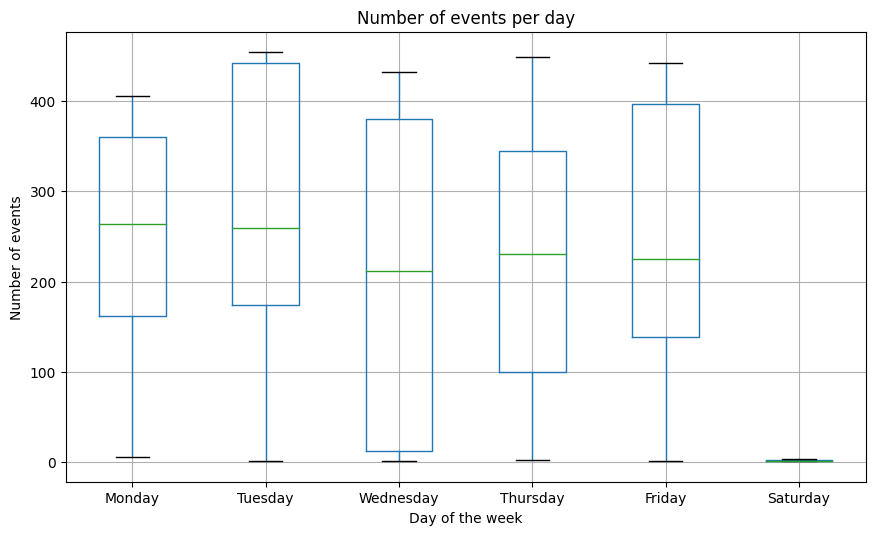

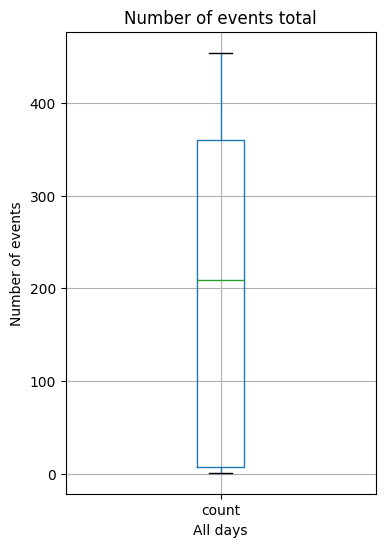

In [12]:
# boxplot
hours_df.boxplot(column='count', by='day', figsize=(10, 6))
plt.title('Number of events per day')
plt.suptitle('')
plt.xlabel('Day of the week')
plt.ylabel('Number of events')
plt.show()


hours_df.boxplot(column='count', figsize=(4, 6))
plt.title('Number of events total')
plt.xlabel('All days')
plt.ylabel('Number of events')
plt.show()


In [13]:
Q1 = hours_df['count'].quantile(0.25)
Q3 = hours_df['count'].quantile(0.80)

print(f'Q1: {Q1}')
print(f'Q3: {Q3}')

Q1: 6.75
Q3: 393.0


## Part 2 : Visualize the data

Text(0.5, 1.1, 'Hours count heatmap of ESIR (2022-2023) schedule')

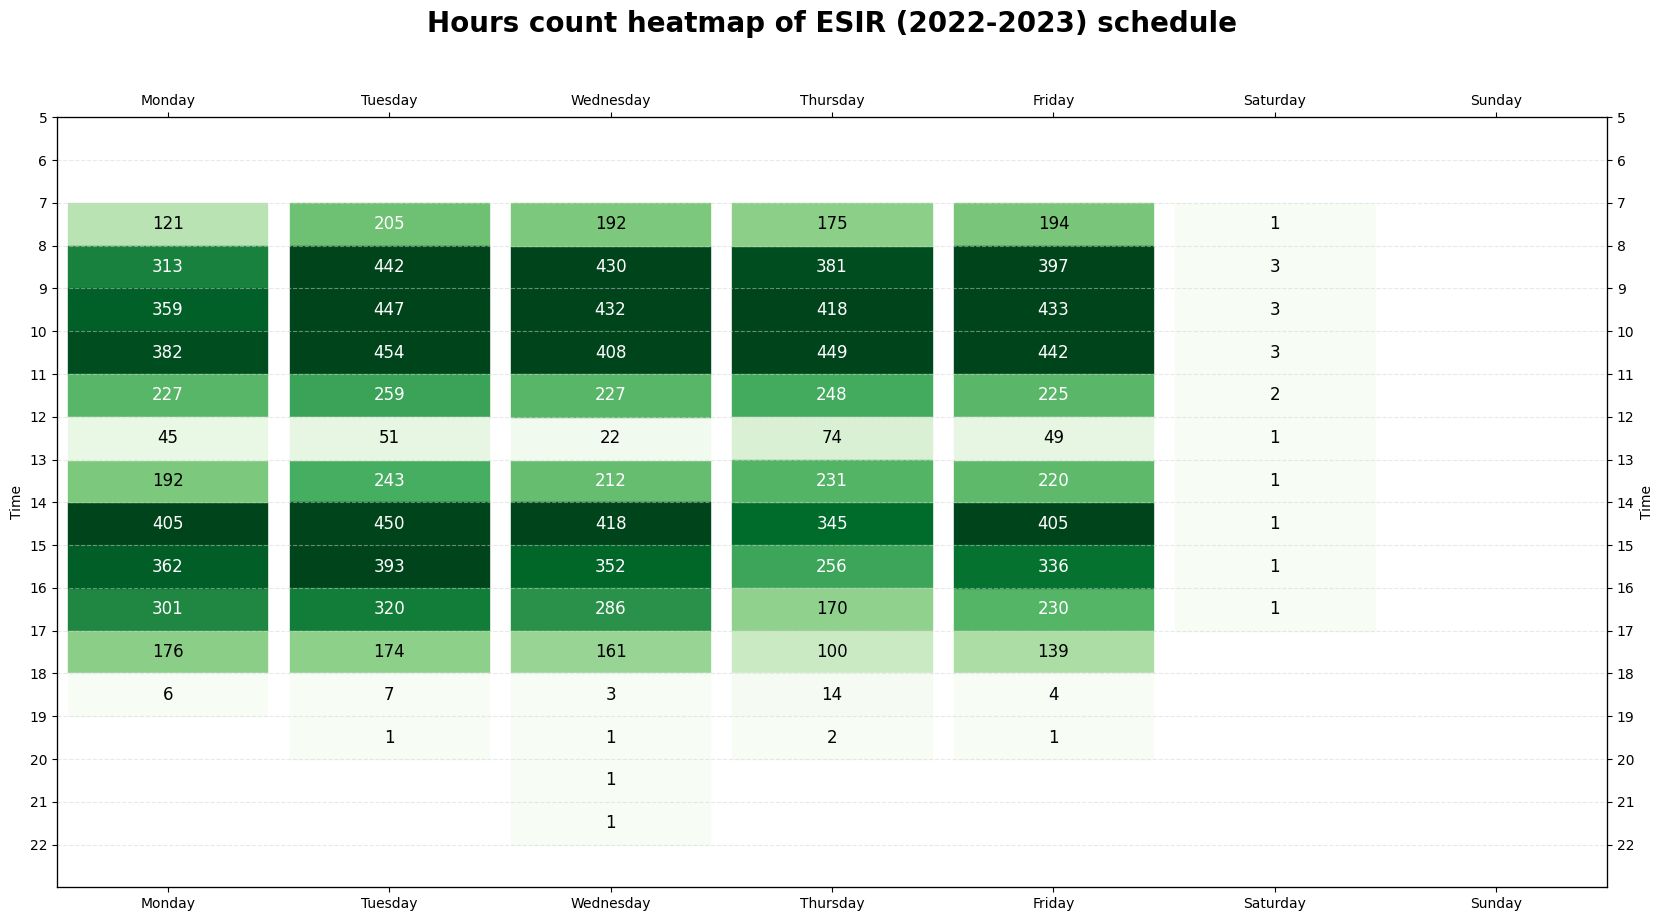

In [14]:

day_to_index = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
max_count = max(hours.values())

# Plot the events
for key in hours.keys():
    hour, day = key
    count = hours[key]
    if day not in day_to_index:
        print('Day {0} not found'.format(day))
        continue
    day_index = day_to_index[day]
    start_hour = hour
    end_hour = hour+1
    
    # Compute the color based on the count and quantiles
    normalized_count = (count-Q1)/(Q3-Q1)
    color =  plt.cm.Greens(normalized_count)
    font_color = 'w' if normalized_count > 0.5 else 'k'
    ax.fill_between([day_index-.45, day_index+.45], [start_hour, start_hour], [end_hour,end_hour], color=color)
    
    # plot event count in this box
    plt.text(day_index, (start_hour+end_hour)*0.5, count, ha='center', va='center', fontsize=12, color=font_color)


# Set Axis

# dot grid
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.5)
ax.set_ylim(23, 5)
ax.set_yticks(range(5,23))
ax.set_ylabel('Time')
ax.set_xlim(0.5,len(day_to_index)+0.5)
ax.set_xticks(range(1,len(day_to_index)+1))
ax.set_xticklabels(day_to_index.keys())

# Set Second Axis
ax2=ax.twiny().twinx()
ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(ax.get_yticks())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(day_to_index.keys() )
ax2.set_ylabel('Time')

# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.gist_heat, norm=plt.Normalize(vmin=0, vmax=max_count))

plt.title(f"Hours count heatmap of {data_name} schedule", fontsize=20, fontweight='bold', y=1.10)

# Feature : Visualize activity per day of the year

In [15]:

def getDate( dt ):
    return pd.to_datetime(dt.date())

# Initialize a Counter with 0 for each day
days = Counter()
start = df['start_time'].min()
end = df['end_time'].max()
cursor = start
while cursor < end:
    days[getDate(cursor)] = 0
    cursor += pd.Timedelta(days=1)


# Count the number of hours per day
for event in df.itertuples():
    days[getDate(event.start_time)] += event.duration.total_seconds()/3600

# Create a DataFrame from the Counter
days_df = pd.DataFrame.from_dict(days, orient='index', columns=['count'])
days_df.head()

,count
2022-09-01,16.75
2022-09-02,29.00
2022-09-03,0.00
2022-09-04,0.00
2022-09-05,59.50


Text(0.5, 1.02, 'Cumulative hours per day of ESIR (2022-2023) schedule')

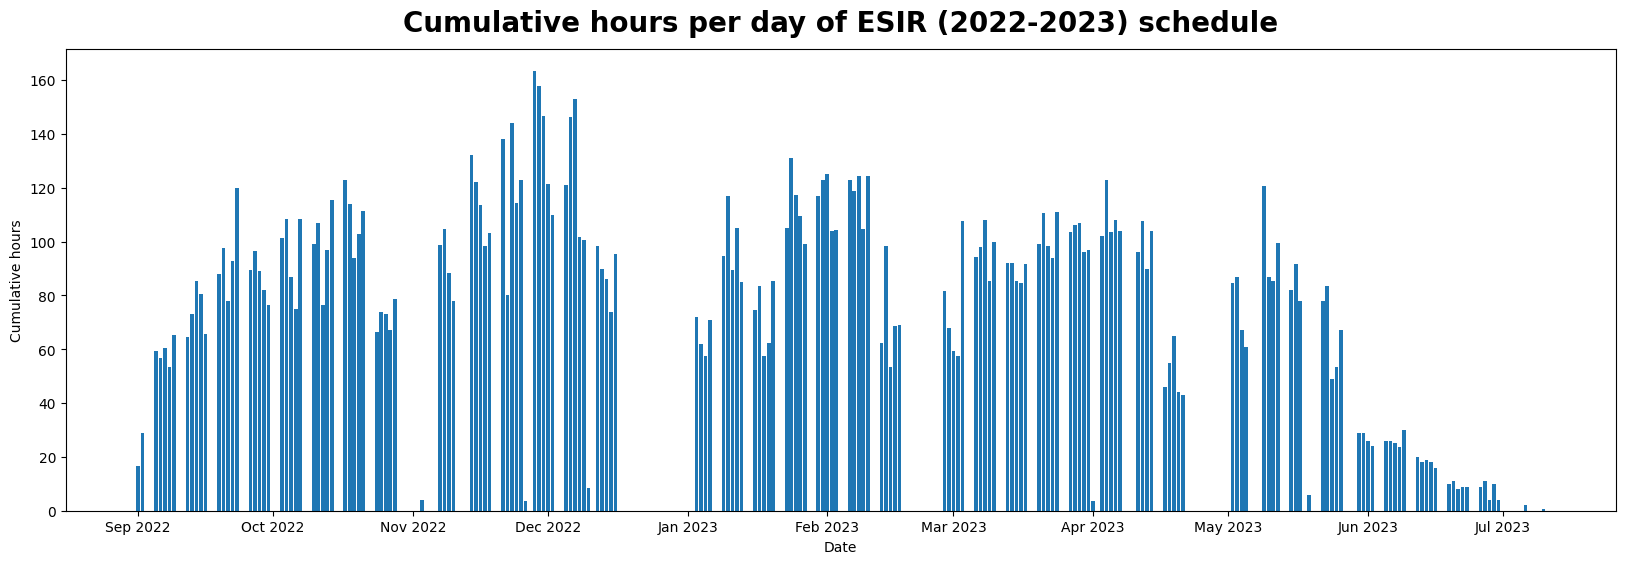

In [16]:
# Sort the data by index
days_df = days_df.sort_index()

# Plot the data
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(days_df.index, days_df['count'])

# Customize the x-axis tick labels
months = pd.date_range(days_df.index.min(), days_df.index.max(), freq='MS')
month_labels = [month.strftime("%b %Y") for month in months]
ax.set_xticks(months)
ax.set_xticklabels(month_labels, rotation=0, ha='center')


# Customize the plot
plt.ylabel('Cumulative hours')
plt.xlabel('Date')
plt.title(f"Cumulative hours per day of {data_name} schedule", fontsize=20, fontweight='bold', y=1.02)

> **Observation** : We can clearly see the crevasses of the holidays and weekends.
> 
> We also see a big drop in activity by the end of may, which is the end of the school year for some students but not for all.
> 
> It then drop down to 0 at the end of july, which is the end of the school year for all students.

# Feature : Prediction of activity

## Part 1 : Smooth the data

First, we need to smooth the data to get a better prediction because the data is very noisy wich cause some overfitting.

Text(0.5, 0, 'Date')

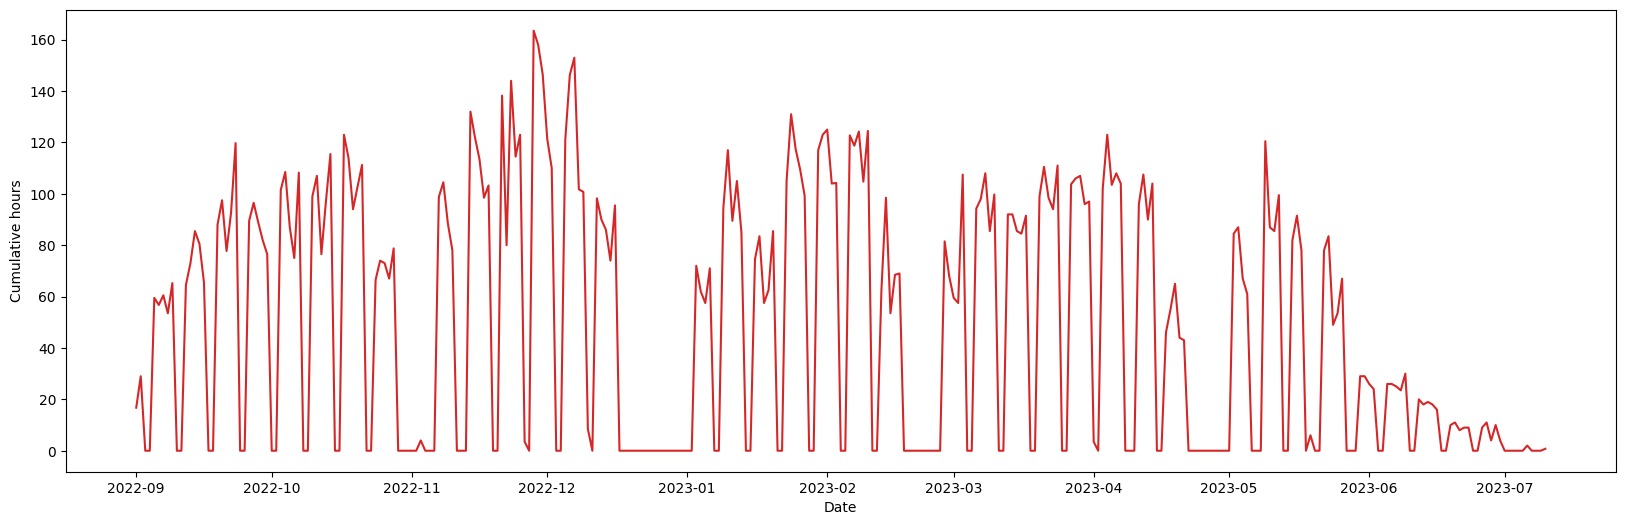

In [17]:
x = days_df.index
y = days_df['count']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y, color='tab:red')
# Customize the plot
plt.ylabel('Cumulative hours')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

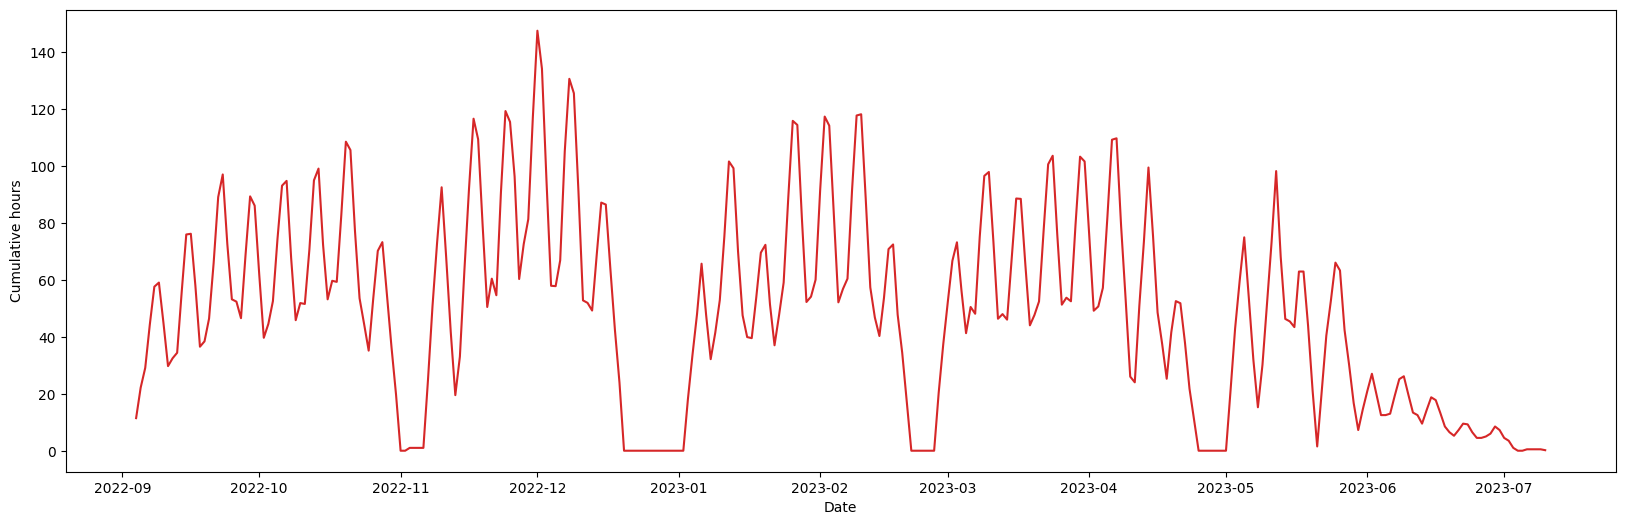

In [18]:
SLIDING_WINDOW_SIZE = 4

# Compute the rolling mean
y_rolling = y.rolling(SLIDING_WINDOW_SIZE).mean()


# Plot the data
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y_rolling, color='tab:red')
# Customize the plot
plt.ylabel('Cumulative hours')
plt.xlabel('Date')

With the rolling mean, we can smooth the data by taking the mean of neighboring days.
The problem we see above is that the weekends have too much weight in the mean, so we will not take them into account.

Text(0.5, 0, 'Date')

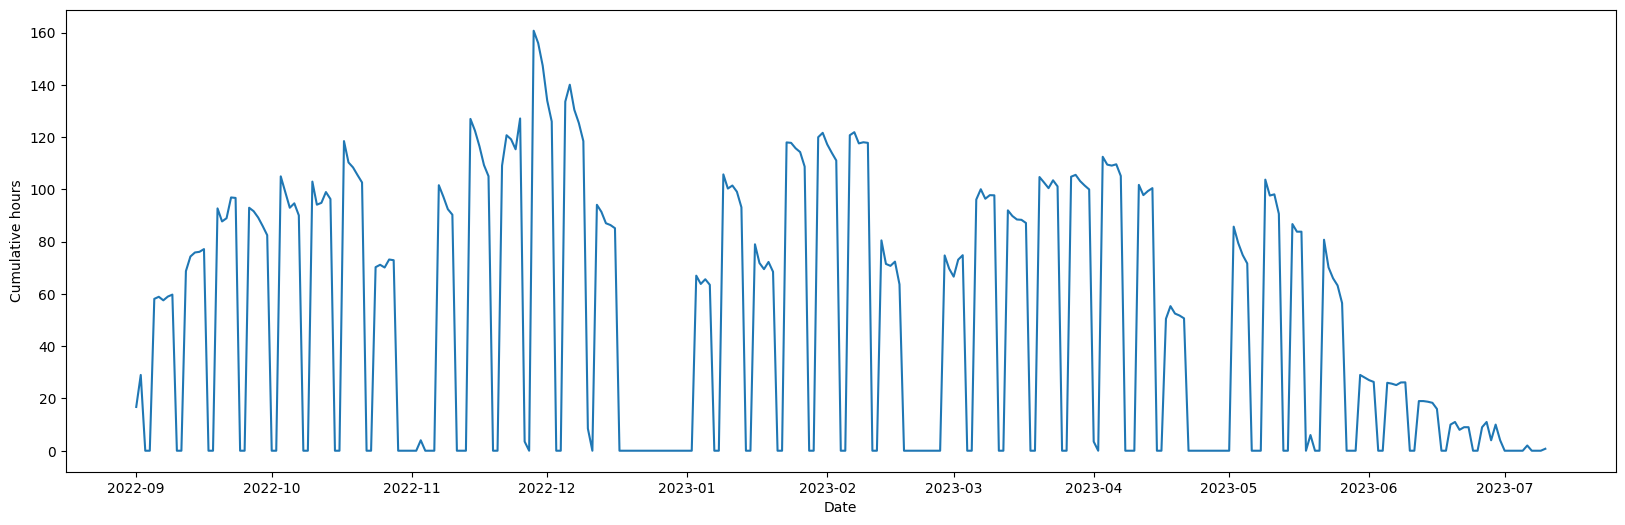

In [19]:
TRESHOLD = max(y) * .1  # in percentage

y_rolling = y.copy()

# Compute the rolling mean
for i in range(SLIDING_WINDOW_SIZE//2 , len(y) - SLIDING_WINDOW_SIZE//2):
    if y[i] < TRESHOLD:
        continue
    values = y[i-SLIDING_WINDOW_SIZE//2:i+SLIDING_WINDOW_SIZE//2]
    # filter out values under the TRESHOLD
    values = values[values > TRESHOLD]
    y_rolling[i] = values.mean()


# Plot the data
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y_rolling, color='tab:blue')
# Customize the plot
plt.ylabel('Cumulative hours')
plt.xlabel('Date')

The function is now more representative of the activity overrall.

> **Observation** : We can notice some curved bumps splited by the holidays.

## Part 2 : Normalize the data

Now that we have our density function for the prediction, we would like to know what the scale corresponds to.
The easiest way to do that is to normalize the data so that we can get a percentage of the total activity.

We should not into account outliers, so we will use the quantiles to get the min and max and normalize the data.

Text(2022-09-01 00:00:00, 4, 'Min: 0.00 cumulative hours')

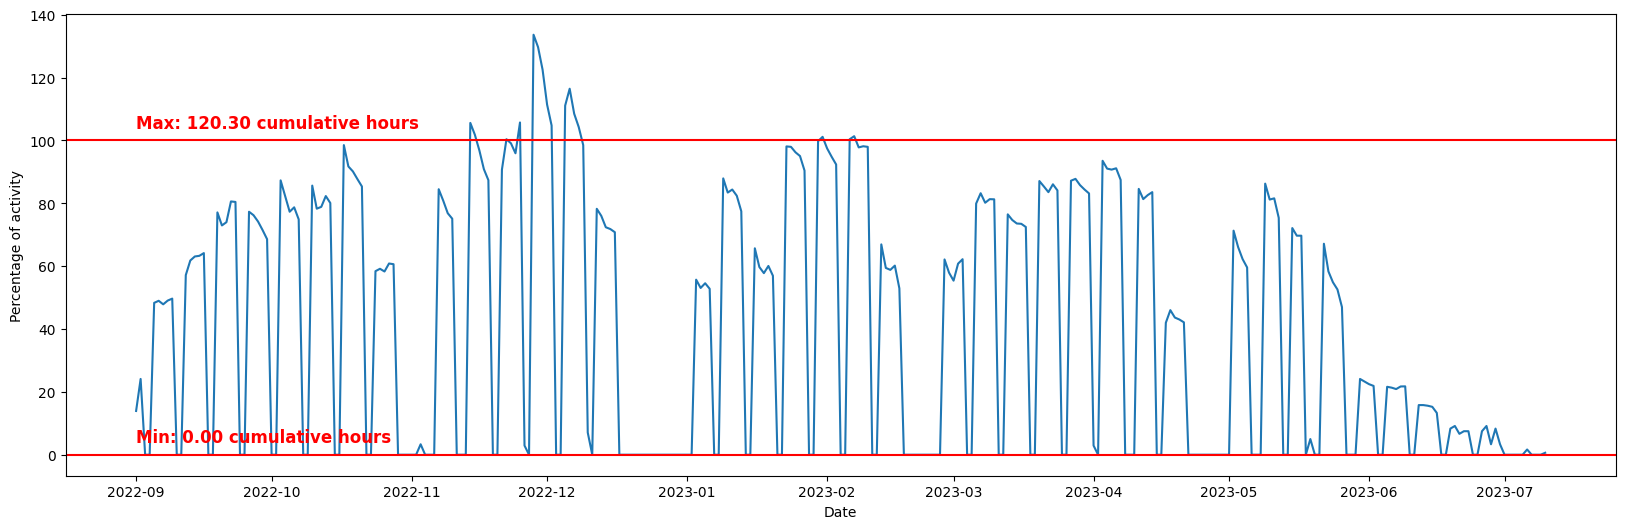

In [20]:
# make the y into a percentage

# quantile normalization with treshold
min_y = 0
max_y = y_rolling.quantile(0.95)
y_norm = 100 * (y_rolling - min_y) / (max_y - min_y) 

# Plot 
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y_norm, color='tab:blue')

# Customize the plot
plt.ylabel('Percentage of activity')
plt.xlabel('Date')

# horizontal line for quantile normalization
plt.axhline(y=100, color='r', linestyle='-')
plt.axhline(y=0, color='r', linestyle='-')

# Add text for min and max
plt.text(x[0], 100 + 4, f"Max: {max_y:.2f} cumulative hours", fontsize=12, color='r', fontweight='bold')
plt.text(x[0], 0 + 4, f"Min: {min_y:.2f} cumulative hours", fontsize=12, color='r', fontweight='bold')


## Part 3 : Predict the activity for today

Let's now predict the activity for today as an example.

C:\Users\codya\AppData\Local\Temp\ipykernel_16336\356490446.py:15: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  today_index = x.get_loc(today, method='nearest')


Text(2023-05-17 11:53:41.116916, 69.68689387642006, '69.69%')

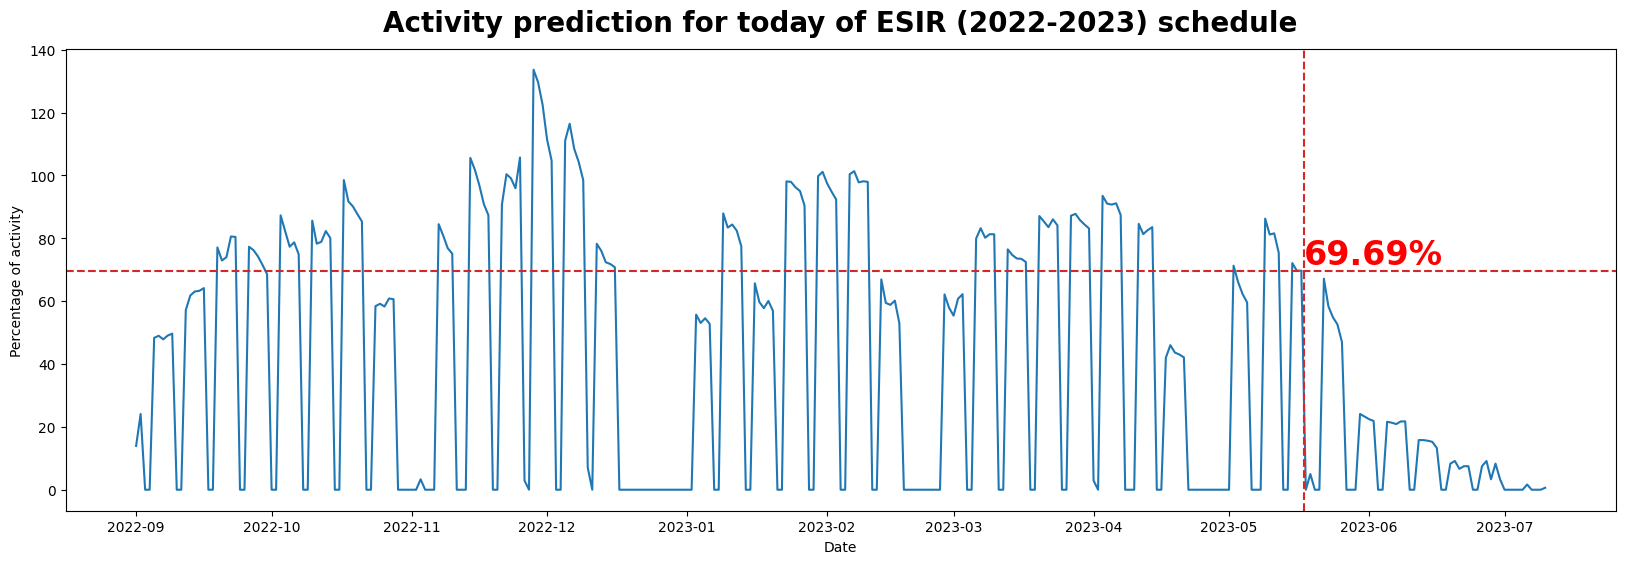

In [21]:
# Plot 
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y_norm, color='tab:blue')

# Customize the plot
plt.ylabel('Percentage of activity')
plt.xlabel('Date')
plt.title(f"Activity prediction for today of {data_name} schedule", fontsize=20, fontweight='bold', y=1.02)

# Add a vertical line for today
today = datetime.datetime.now()
ax.axvline(today, color='tab:red', linestyle='--')

# Add a horizontal line for activity of today
today_index = x.get_loc(today, method='nearest')
today_activity = y_norm[today_index]
ax.axhline(today_activity, color='tab:red', linestyle='--')

# Add a text for today's activity (in bold and red)
ax.text(today, today_activity, f'{today_activity:.2f}%', ha='left', va='bottom', color='red', fontsize=24 , fontweight='bold')



# Feature : Visualize the rooms occupation

## Part 1 : Building visualization

In [22]:

building_regex = r"(\bB\d{2}\w*)|(distanciel)"

def get_building(location):
    matches = re.findall(building_regex, location, re.IGNORECASE)
    if len(matches) > 0:
        bat,dist = matches[0]
        if bat:
            return bat.upper()
        return dist.upper()
    else:
        return "UNKNOWN"

df["building"] = df["location"].apply(get_building)


Text(0, 0.5, 'Building')

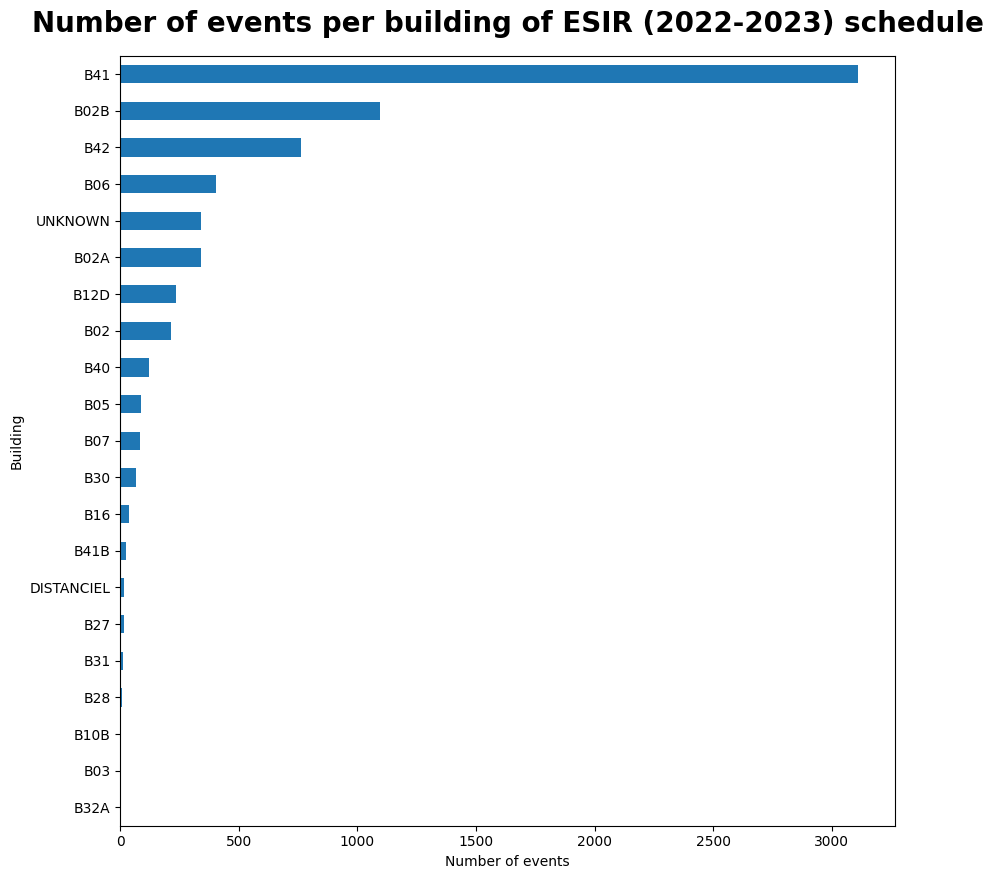

In [23]:
# plot horizontal bar chart biggest to smallest
df["building"].value_counts().plot(kind='barh', figsize=(10, 10)).invert_yaxis()
plt.title(f"Number of events per building of {data_name} schedule", fontsize=20, fontweight='bold', y=1.02)
plt.xlabel('Number of events')
plt.ylabel('Building')

Can may notice some `UNKNOWN` values. Those are buildings that are not labeled with the correct format (`r"\bB\d{2}\w*"`) or did not have any label at all.

Here are some of the not found buildings:

In [24]:
# Print some "Not found" buildings
to_print = None
try:
    to_print = df[df["building"] == "UNKNOWN"].sample(10)
except:
    pass
to_print

,start_time,end_time,summary,description,location,duration,building
6260,2022-11-10 12:30:00+00:00,2022-11-10 18:30:00+00:00,SPORT ESIR,\n\n004 SI ESIR3\n004 MAT ESIR3\n004 IoT ESIR3...,,0 days 06:00:00,UNKNOWN
3774,2023-03-29 14:15:00+00:00,2023-03-29 18:15:00+00:00,ENTREP - Travail en autonomie,\n\n006 VUE ESIR2 FISA MAT\n\n(Updated :13/02/...,,0 days 04:00:00,UNKNOWN
3778,2022-11-17 14:00:00+00:00,2022-11-17 18:00:00+00:00,Projet industriel,\n\n004 IN ESIR3\n004 TIS ESIR3\n004 SI ESIR3\...,,0 days 04:00:00,UNKNOWN
3966,2023-03-01 08:00:00+00:00,2023-03-01 10:00:00+00:00,MNGT9 - TD Gestion de production Gr 3 (PRO),\n\n004 TOUT ESIR3 FISE\n004 IN ESIR3\n004...,Parking 4 - Salle modulaire 2,0 days 02:00:00,UNKNOWN
800,2022-10-25 07:00:00+00:00,2022-10-25 11:00:00+00:00,Projet industriel,\n\n004 TOUT ESIR3 FISE\n004 SI ESIR3\n004...,,0 days 04:00:00,UNKNOWN
4407,2023-01-26 13:30:00+00:00,2023-01-26 18:30:00+00:00,Visite Excelcar,\n\n004 MAT ESIR3\n004 TOUT ESIR3 FISE\n\n...,salle extérieure,0 days 05:00:00,UNKNOWN
1877,2023-05-26 13:00:00+00:00,2023-05-26 15:00:00+00:00,CC MATHS-S4,\n\n001-2 VUE CUPGE 2\n00 étudiants CUPGE 2\nK...,Parking 4 - Salle modulaire 2,0 days 02:00:00,UNKNOWN
1443,2023-03-28 07:00:00+00:00,2023-03-28 08:30:00+00:00,S2-allemand 8h-9h30 SCELVA B27-206,\n\n001-1 VUE CUPGE 1\nallemand cupge1\n\n(Upd...,,0 days 01:30:00,UNKNOWN
5834,2022-10-28 07:00:00+00:00,2022-10-28 08:30:00+00:00,S3-espagnol 8h-9H30 SCELVA B26-004,\n\n001-2 VUE CUPGE 2\nespagnol cupge2\n\n(Upd...,,0 days 01:30:00,UNKNOWN
459,2023-03-16 13:30:00+00:00,2023-03-16 19:30:00+00:00,SPORT ESIR,\n\n004 SI ESIR3\n004 MAT ESIR3\n004 IoT ESIR3...,,0 days 06:00:00,UNKNOWN


## Part 2 : Rooms visualization

In [25]:
room_regex = r"\b\d{3}\b"

def get_room(location):
    matches = re.findall(room_regex, location)
    if len(matches) > 0:
        return matches[0]
    else:
        return "NO ROOM"

df["room"] = df["location"].apply(get_room)
df["room"]

df["bat room"] = df["building"] + " - " + df["room"]

Text(0, 0.5, 'Room (Top 30)')

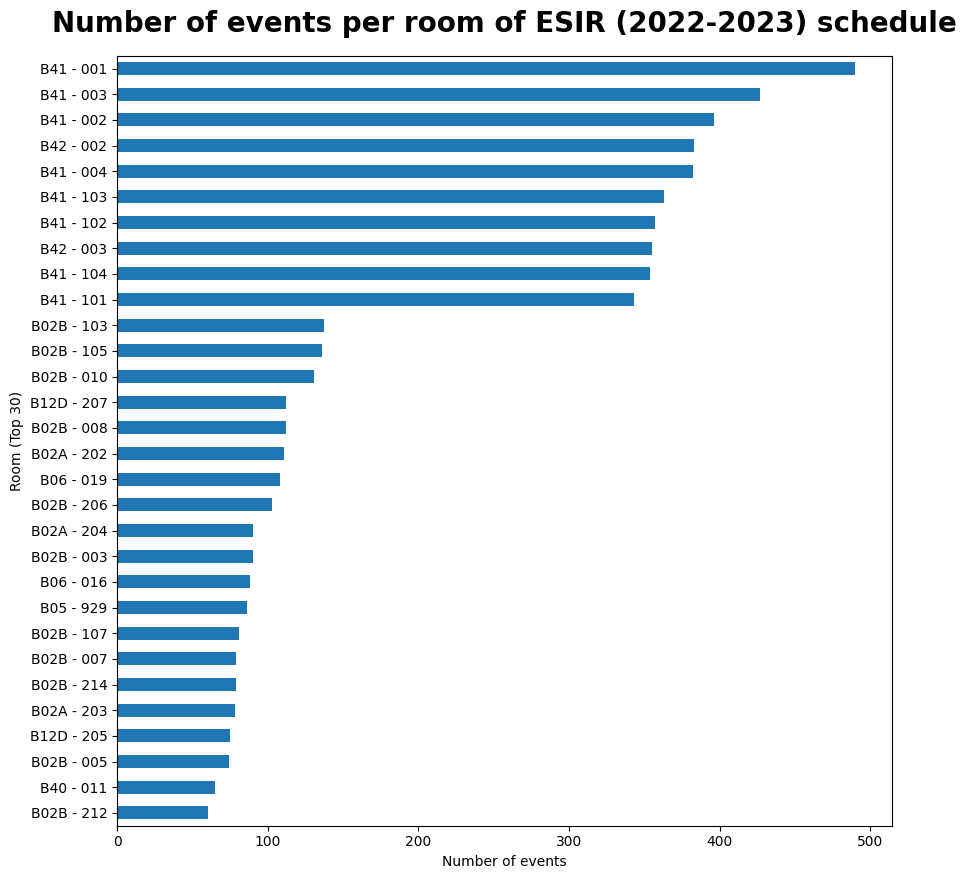

In [26]:
# plot horizontal bar chart biggest to smallest
## only show the top 30
## Remove the "NO ROOM" ones
sorted_df = df[df["room"] != "NO ROOM"]["bat room"].value_counts().sort_values(ascending=False).head(30)
sorted_df.plot(kind='barh', figsize=(10, 10)).invert_yaxis()
plt.title(f"Number of events per room of {data_name} schedule", fontsize=20, fontweight='bold', y=1.02)
plt.xlabel('Number of events')
plt.ylabel('Room (Top 30)')


> **Observation** : Event tho the most used building is the B02A, the most used room is the B41 - 001 from ESIR.
>
> This is quite interesting since there are less ESIR students than generic University students that use the B02A.
>
> We can make a hypothesis that the B41 - 001 is more often used because of the lower number of rooms that ESIR has in comparison to the B02A which is a big building with a lot of rooms to share the higher demand and spread the activity.

Text(0, 0.5, 'Room in building B41')

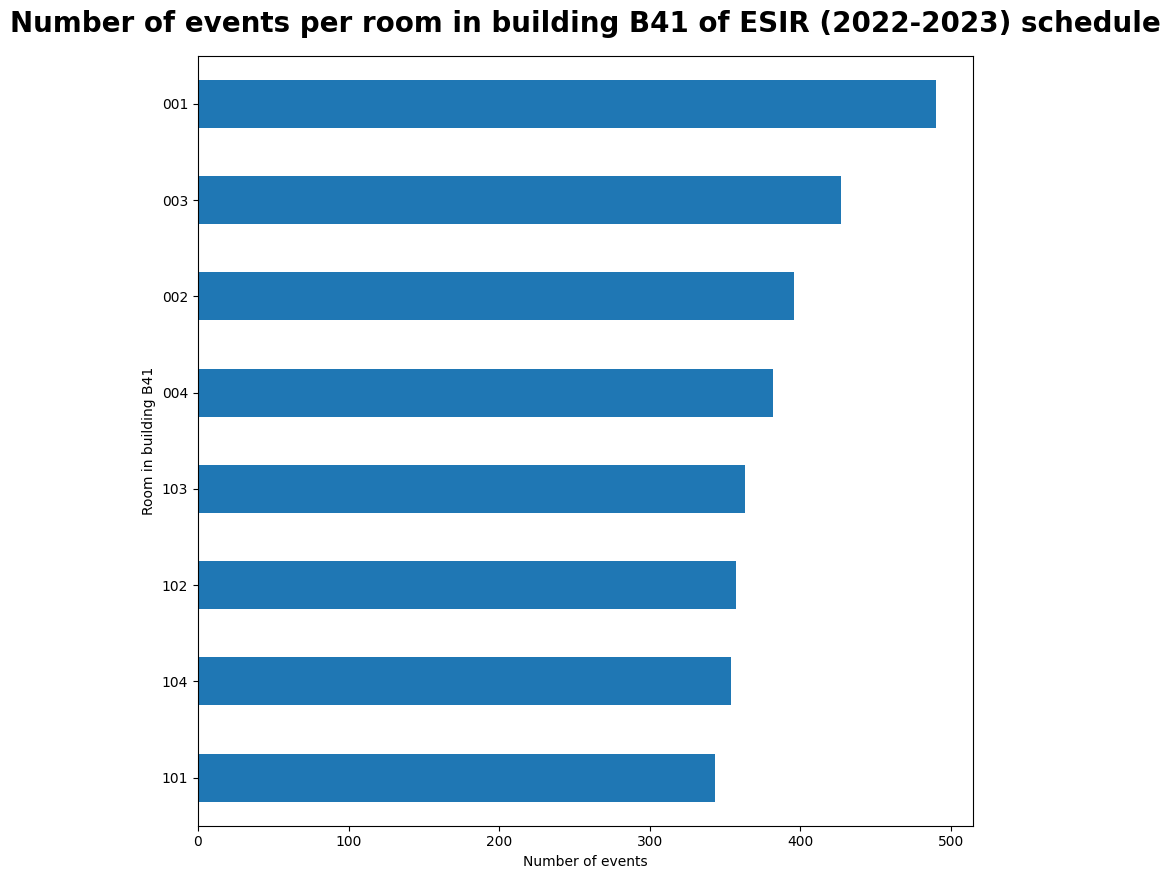

In [27]:
# plot horizontal bar chart biggest to smallest

building = "B41"

df["room"][df["building"] == building].value_counts().plot(kind='barh', figsize=(10, 10)).invert_yaxis()
plt.title(f"Number of events per room in building {building} of {data_name} schedule", fontsize=20, fontweight='bold', y=1.02)
plt.xlabel('Number of events')
plt.ylabel(f'Room in building {building}')

> **Observation** : We can see a strong attraction for the rooms `101` which is very interesting because it is the same room as the other one.
>
> This may be due to the fact that the room is the first one in the list of rooms because of alphabetical order. Which doesn't make sense with the rest of the rooms.